At least a bit of my own code, informed by chapter 17 in Kruschke 2nd ed, along with code from http://nbviewer.ipython.org/github/welch/stats-notebooks/blob/master/SimpleLinearRegression.ipynb and http://sabermetricinsights.blogspot.com/2014/05/bayesian-linear-regression-with-pymc.html.

In [13]:
%pylab inline
import pymc as pm
import pandas as pd
import pymc.graph
from IPython.display import Image # to render png from pydot inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('HtWtData30.csv')

In [3]:
data

,male,height,weight
0,0,64.0,136.4
1,0,62.3,215.1
2,1,67.9,173.6
3,0,64.2,117.3
4,0,64.8,123.3
5,0,57.5,96.5
6,0,65.6,178.3
7,1,70.2,191.1
8,0,63.9,158.0
9,1,71.1,193.9


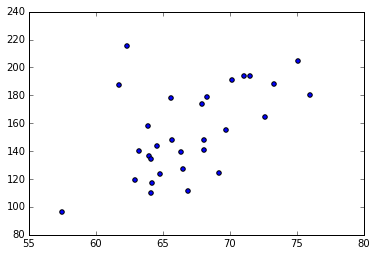

In [4]:
plt.scatter(data.height, data.weight)

In [5]:
print data.height.mean()
print data.height.std()
print data.weight.mean()
print data.weight.std()

66.9833333333
4.20107402797
154.013333333
31.7025696047


The approach is at least somewhat different from that in the book, but the ideas at http://sabermetricinsights.blogspot.com/2014/05/bayesian-linear-regression-with-pymc.html seem simpler, so i'll start there, changing to height and weight (instead of the mpg used in the example).

In [6]:
# priors for intercept (b0) and slope (b1) are normal with very large
# variances (which correspond to tiny precisions, as used in the constructor)
b0 = pm.Normal('b0', 0, 0.0003)
b1 = pm.Normal('b1', 0, 0.0003)

# error - which we use explicitly in this example - is uniform
err = pm.Uniform('err', 0, 500)

In [28]:
# we'll predict weight based on height, so we want a variable
# that holds our observed heights. The notes say that using Normal
# here doesn't matter since this is observed - not sure I understand
# this. This doesn't (i think) represent our likelihood function,
# since i think we do that below when we get out y (?). It feels
# odd to provide two sets of data in 'observed' variables - other
# examples (Kruschke too?) don't do this?
# see also the note at the bottom of the post where the author
# talks about this, I think.
x_height = pm.Normal('x_height', 0, 1, value=np.array(data.height),
                     observed=True)

In [8]:
# 'heart of our model'?
@pm.deterministic
def pred(b0=b0, b1=b1, x=x_height):
    return b0 + b1*x

In [20]:
# now i think we provide our y values, and the Normal here is 
# actually used... ?
y_weight = pm.Normal('y_weight', pred, err, value=np.array(data.weight),
              observed=True)

In [21]:
model = pm.Model([pred, b0, b1, y_weight, err, x_height])

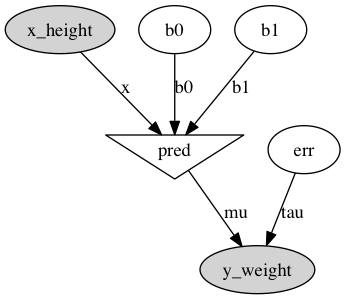

In [22]:
graph = pm.graph.graph(model)
Image(graph.create_png())

In [23]:
mcmc = pm.MCMC(model)
mcmc.sample(50000, 20000)

 [-----------------100%-----------------] 50000 of 50000 complete in 8.0 sec

2.91562435207


(array([  110.,    44.,   109.,   204.,  1009.,  1689.,  1945.,  2966.,
         4472.,  4742.,  4197.,  3874.,  2512.,   735.,   465.,   379.,
          151.,   261.,   124.,    12.]),
 array([ 0.82482715,  1.04465836,  1.26448956,  1.48432076,  1.70415197,
         1.92398317,  2.14381437,  2.36364558,  2.58347678,  2.80330798,
         3.02313919,  3.24297039,  3.46280159,  3.6826328 ,  3.902464  ,
         4.12229521,  4.34212641,  4.56195761,  4.78178882,  5.00162002,
         5.22145122]),
 <a list of 20 Patch objects>)

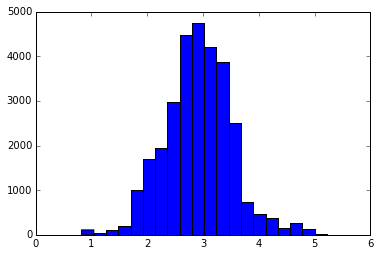

In [26]:
b1_trace = mcmc.trace('b1')[:]

# this is the average weight increase per unit of height increase?
print np.mean(b1_trace) 

plt.hist(b1_trace, bins=20)

-41.0687561713


(array([   52.,   228.,   150.,   178.,   520.,   460.,  1082.,  3094.,
         3758.,  4274.,  4770.,  4112.,  2505.,  1827.,  1693.,   820.,
          221.,    92.,    59.,   105.]),
 array([-187.39513636, -173.13327463, -158.8714129 , -144.60955116,
        -130.34768943, -116.0858277 , -101.82396597,  -87.56210423,
         -73.3002425 ,  -59.03838077,  -44.77651903,  -30.5146573 ,
         -16.25279557,   -1.99093384,   12.2709279 ,   26.53278963,
          40.79465136,   55.05651309,   69.31837483,   83.58023656,
          97.84209829]),
 <a list of 20 Patch objects>)

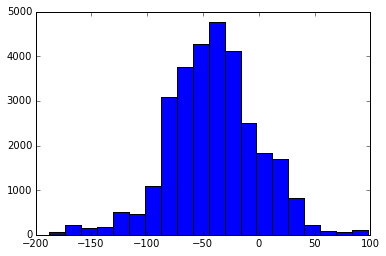

In [27]:
b0_trace = mcmc.trace('b0')[:]
print np.mean(b0_trace)
plt.hist(b0_trace, bins=20)